# ann-project

5조
한수호, 강구현, 김민규, 홍준기

# Setup

In [22]:
from models.simple_cnn import CNNModel
from models.residual import ResModel
from models.resnet50 import ResNetModel
from models.lenet import LeNetModel
from keras import callbacks, optimizers, layers, losses
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import seaborn as sns
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [3]:
from datetime import datetime
result_path = './results'
_time = datetime.strftime(datetime.today(), '%Y-%m-%d_%H-%M-%S')

dataset

In [4]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

x_train = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 62)
y_test = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 62)

y_train_int = train_data.iloc[:, 0].to_numpy()
y_test_int = test_data.iloc[:, 0].to_numpy()

_, _, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train, x_valid, y_train_int, y_valid_int = train_test_split(x_train, y_train_int, test_size=0.1, random_state=42)

x_train_resized = tf.image.resize(x_train, [32, 32])
x_valid_resized = tf.image.resize(x_valid, [32, 32])
x_test_resized = tf.image.resize(x_test, [32, 32])

2024-06-01 20:52:12.694189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 20:52:12.719588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 20:52:13.020200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

checkpoints

In [5]:
def create_callbacks(model_name):
    current_time = int(time.time())
    checkpoint_path = f"./checkpoints/checkpoints_{model_name}/weights.{current_time}.hdf5"
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                             min_delta=0.0001, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
    checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    return [early_stopping, reduce_lr, checkpoint]


callbacks_lenet = create_callbacks('lenet')
callbacks_resnet = create_callbacks('resnet')
callbacks_ours_1 = create_callbacks('ours_1')
callbacks_ours_2 = create_callbacks('ours_2')
callbacks_final = create_callbacks('final')
result_path = './results'

test results

In [6]:
def save_results(results_df):
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    results_df.to_csv(os.path.join(result_path, f'result_{_time}.csv'), index=False)

saving history

In [7]:
def save_history(histories, filename):
    with open(os.path.join(result_path, filename), 'w') as f:
        json.dump(histories, f)

# 1. baseline과 our 모델 비교

In [ ]:
# Initialize models
lenet_model = LeNetModel()
resnet_model = ResNetModel()
our_model_1 = CNNModel()
our_model_2res = ResModel()

# Compile models
lenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = []
training_time = []

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
start_time = time.time()
history.append(lenet_model.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_lenet]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(resnet_model.train(x_train_resized, y_train_int, validation_data=(x_valid_resized,
               y_valid_int), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_resnet]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(our_model_1.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_1]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(our_model_2res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_2]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
loss_lenet, acc_lenet = lenet_model.evaluate(x_test, y_test_int)
loss_resnet, acc_resnet = resnet_model.evaluate(x_test_resized, y_test_int)
loss_our1, acc_our1 = our_model_1.evaluate(x_test, y_test_int)
loss_our2, acc_our2 = our_model_2res.evaluate(x_test, y_test_int)

In [ ]:
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model(CNN)", "Our Model(Residual)"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_{_time}.csv', index=False)

In [ ]:
models = ["lenet-5", "resnet-50", "our_model_cnn", "our_model_residual"]
for model_name, h in zip(models, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_{model_name}_{_time}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
plt.show()
save_history(history, f'history_activation_{_time}.pkl')

In [ ]:
training_time.append("")
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model", "Wavemix-256[6]"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2, 0],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2, 0.8842],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()

# 2. Experiment

## 2.1. Optimizer

In [ ]:
optimizers_list = [
    optimizers.SGD(learning_rate=0.001, momentum=0.9),
    optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    optimizers.Adagrad(learning_rate=0.001),
    optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
]

In [ ]:
history = []
results = {'Optimizer': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
def _train_opt(x_train, y_train, validation_data, optimizer, activation_ftn='ReLU'):
    print(f"Start with {type(optimizer).__name__}")
    final_model = ResModel(num_classes=62, initial_filters=32,
                           dropout_rate=0.3, final_dropout_rate=0.6, activation=activation_ftn, num_residual_units=3)
    optimizer.build(final_model.model.trainable_variables)

    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Optimizer'].append(type(optimizer).__name__)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

    print(f"End with {type(optimizer).__name__}")

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
for optimizer in optimizers_list:
    _train_opt(x_train, y_train_int, (x_valid, y_valid_int), optimizer, activation_ftn='ReLU')

In [ ]:
results_df = pd.DataFrame(results)
save_results(results_df)
for optimizer, h in zip(optimizers_list, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_optimizer_{type(optimizer).__name__}_{_time}.json')

In [ ]:
plt.figure(figsize=(14, 6))

for i, h in enumerate(history):
    plt.subplot(1, 2, 1)
    plt.plot(h.history['accuracy'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(h.history['loss'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
plt.show()

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Optimizer", y=metric, hue="Optimizer", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Optimizer')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()

## 2.2. Activation Function

In [ ]:
activations = {
    'relu': layers.ReLU(),
    'leaky_relu': layers.LeakyReLU(),
    'elu': layers.ELU(),
    'selu': layers.Activation('selu'),
    'sigmoid': layers.Activation('sigmoid'),
    'tanh': layers.Activation('tanh'),
    'softmax': layers.Activation('softmax'),
    'softplus': layers.Activation('softplus'),
    'softsign': layers.Activation('softsign'),
    'swish': layers.Activation('swish'),
    'gelu': layers.Activation('gelu')
}

In [ ]:
history = []
results = {'Activation Function': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
best_optimizer = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
activation_functions = ['relu', 'leaky_relu', 'elu', 'selu', 'sigmoid', 'tanh',
                        'softmax', 'softplus', 'softsign', 'swish', 'gelu']

In [ ]:
def _train_act(x_train, y_train, validation_data, optimizer, activation_ftn):
    print(f"Start with {activation_ftn}")

    activation_layer = activations.get(activation_ftn, layers.ReLU())

    final_model = ResModel(num_classes=62, initial_filters=32, dropout_rate=0.3,
                           final_dropout_rate=0.6, activation=activation_layer, num_residual_units=3)
    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Activation Function'].append(activation_ftn)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

    print(f"End with {activation_ftn}")

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
for ftn in activation_functions:
    _train_act(x_train, y_train_int, (x_valid, y_valid_int), optimizer=best_optimizer, activation_ftn=ftn)

In [ ]:
results_df = pd.DataFrame(results)
save_results(results_df)
for activation, h in zip(activation_functions, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_activation_{activation}_{_time}.json')

In [ ]:
len(history)

In [ ]:
plt.figure(figsize=(14, 6))

for i in range(len(activation_functions)):
    plt.subplot(1, 2, 1)
    plt.plot(history[i].history['accuracy'], label=f'{activation_functions[i]} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history[i].history['loss'], label=f'{activation_functions[i]} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig(f"{result_path}/result_activation_{_time}.png")
plt.show()

In [ ]:
display(results_df)

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Loss", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Loss"} Comparison')
plt.ylabel("Loss")
plt.xlabel('Activation Function')
plt.tight_layout()
plt.savefig(f'{result_path}/{"Loss".lower().replace(" ", "_")}_comparison_{_time}.png')

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Accuracy", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Accuracy"} Comparison')
plt.ylabel("Accuracy")
plt.xlabel('Activation Function')
plt.ylim([0.8, 1])
plt.tight_layout()
plt.savefig(f'{result_path}/{"Accuracy".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Training Time", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Training Time"} Comparison')
plt.ylabel("Training Time")
plt.xlabel('Activation Function')
plt.tight_layout()
plt.savefig(f'{result_path}/{"Training Time".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

## 2.3. The number of Residual Blocks

In [ ]:
history = []
training_time = []

In [ ]:
callbacks_final = create_callbacks('final')

In [ ]:
best_optimizer = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
best_activation = 'swish'

In [ ]:
our_model_1res = ResModel(num_residual_units=1, activation=best_activation)
our_model_2res = ResModel(num_residual_units=2, activation=best_activation)
our_model_3res = ResModel(num_residual_units=3, activation=best_activation)
our_model_4res = ResModel(num_residual_units=4, activation=best_activation)

In [ ]:
our_model_1res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_3res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_4res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
def _train_blocks(model, x_train, y_train, validation_data):
    model.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = model.evaluate(x_test, y_test_int)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [ ]:
start_time = time.time()
_train_blocks(our_model_1res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)

start_time = time.time()
_train_blocks(our_model_2res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
_train_blocks(our_model_3res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
_train_blocks(our_model_4res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
loss_our1res, acc_our1res = our_model_1res.evaluate(x_test, y_test_int)
loss_our2res, acc_our2res = our_model_2res.evaluate(x_test, y_test_int)
loss_our3res, acc_our3res = our_model_3res.evaluate(x_test, y_test_int)
loss_our4res, acc_our4res = our_model_4res.evaluate(x_test, y_test_int)

In [ ]:
results = {
    "Model": ["Our Model(Residual, 1 units)", "Our Model(Residual, 2 units)", "Our Model(Residual, 3 units)", "Our Model(Residual, 4 units)"],
    "Loss": [loss_our1res, loss_our2res, loss_our3res, loss_our4res],
    "Accuracy": [acc_our1res, acc_our2res, acc_our3res, acc_our4res],
    "Training Time": training_time
}

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_blocks_{_time}.csv', index=False)

In [ ]:
for i, h in zip(range(1, 5), history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_block_{i}_{_time}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_blocks_{_time}.png")
plt.show()

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_blocks_{_time}.png')
    plt.show()

## 2.4. Learning Rate

In [ ]:
history = []
training_time = []

In [ ]:
callbacks_final = create_callbacks('lr')

In [ ]:
best_optimizer_1 = optimizers.legacy.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
best_optimizer_2 = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
best_optimizer_3 = optimizers.legacy.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
best_optimizer_4 = optimizers.legacy.Nadam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
best_optimizer_5 = optimizers.legacy.Nadam(learning_rate=0.000001, beta_1=0.9, beta_2=0.999)
best_activation = 'swish'

In [ ]:
our_model_1lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_2lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_3lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_4lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_5lr = ResModel(num_residual_units=3, activation=best_activation)

In [ ]:
our_model_1lr.compile(optimizer=best_optimizer_1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2lr.compile(optimizer=best_optimizer_2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_3lr.compile(optimizer=best_optimizer_3, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_4lr.compile(optimizer=best_optimizer_4, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_5lr.compile(optimizer=best_optimizer_5, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
results = {'Learning Rate': ['1e-2', '1e-3', '1e-4', '1e-5', '1e-6'], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:


def _train_lr(model, optimizer, x_train, y_train, validation_data):
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = model.evaluate(x_test, y_test_int)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [ ]:
start_time = time.time()
_train_lr(our_model_1lr, best_optimizer_1, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_1')

start_time = time.time()
_train_lr(our_model_2lr, best_optimizer_2, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_2')


start_time = time.time()
_train_lr(our_model_3lr, best_optimizer_3, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_3')

start_time = time.time()
_train_lr(our_model_4lr, best_optimizer_4, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_4')

start_time = time.time()
_train_lr(our_model_5lr, best_optimizer_5, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_5')

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_lr_{_time}.csv', index=False)

In [ ]:
for i, h in zip(range(1, 4), history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_lr_{i}_{_time}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_lr_{_time}.png")
plt.show()

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Learning Rate", y=metric, hue="Learning Rate", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Learning Rate')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_lr_{_time}.png')
    plt.show()

### 2.4.1. Detailed learning rate

In [ ]:
history = []
training_time = []

In [ ]:
callbacks_final = create_callbacks('lr')

In [ ]:
best_activation = 'swish'

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
results = {'Learning Rate': ['1e−3', '9e−4', '8e−4', '7e−4', '6e−4',
                             '5e−4', '4e−4', '3e−4', '2e−4', '1e−4'], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
def _train_lr(learning_rate, x_train, y_train, validation_data):
    model = ResModel(num_residual_units=3, activation=best_activation)
    _optimizer = optimizers.legacy.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = model.evaluate(x_test, y_test_int)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [ ]:
for i in np.linspace(1e-3, 1e-4, 10):
    start_time = time.time()
    _train_lr(i, x_train, y_train_int, (x_valid, y_valid_int))
    end_time = time.time()
    training_time.append(end_time-start_time)
    callbacks_final = create_callbacks(f'{i}')

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_lr_{_time}.csv', index=False)

In [ ]:
for i, h in zip(['1e−3', '9e−4', '8e−4', '7e−4', '6e−4',
                 '5e−4', '4e−4', '3e−4', '2e−4', '1e−4'], history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_lr_{i}_{_time}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange", "cyan", "magenta", "brown", "pink"]


plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_lr_{_time}.png")
plt.show()

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Learning Rate", y=metric, hue="Learning Rate", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Learning Rate')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_lr_{_time}.png')
    plt.show()

## 2.5. Loss function

In [8]:
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [9]:
history = []
training_time = []

In [10]:
callbacks_final = create_callbacks('loss')

In [11]:
best_activation = 'swish'
best_learning_rate = 2e-4
best_optimizer = optimizers.legacy.Nadam(learning_rate=best_learning_rate, beta_1=0.9, beta_2=0.999)

In [12]:
results = {'Loss Function': ['Cross Entropy Loss', 'Focal Loss'], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [13]:
EPOCHS = 50
BATCH_SIZE = 500

In [23]:
class CategoricalFocalLoss(losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(CategoricalFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        alpha = tf.constant(self.alpha, dtype=tf.float32)
        gamma = tf.constant(self.gamma, dtype=tf.float32)

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        y_true = tf.clip_by_value(y_true, epsilon, 1.0 - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * y_true * tf.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        loss = tf.reduce_sum(loss, axis=1)
        return tf.reduce_mean(loss)

In [24]:
focal_loss = CategoricalFocalLoss(gamma=2.0, alpha=0.25)

model_default = ResModel(num_residual_units=3, activation=best_activation)
model_focal = ResModel(num_residual_units=3, activation=best_activation)
model_default.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_focal.compile(optimizer=best_optimizer, loss=focal_loss, metrics=['accuracy'])

In [25]:
def _train_losses(model, x_train, y_train, validation_data):
    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = model.evaluate(x_test, y_test_int)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [26]:
_train_losses(model_default, x_train, y_train_int, (x_valid, y_valid_int))
_train_losses(model_focal, x_train, y_train_int, (x_valid, y_valid_int))

Epoch 1/50


2024-06-01 21:35:30.533528: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1256/1257 [============================>.] - ETA: 0s - loss: 1.3941 - accuracy: 0.6350
Epoch 1: val_loss did not improve from -625411456.00000
1257/1257 [==============================] - 35s 26ms/step - loss: 1.3940 - accuracy: 0.6350 - val_loss: 0.6888 - val_accuracy: 0.7845 - lr: 1.2500e-05
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.8094 - accuracy: 0.7578
Epoch 2: val_loss did not improve from -625411456.00000
1257/1257 [==============================] - 33s 26ms/step - loss: 0.8094 - accuracy: 0.7578 - val_loss: 0.5366 - val_accuracy: 0.8224 - lr: 1.2500e-05
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.7891
Epoch 3: val_loss did not improve from -625411456.00000
1257/1257 [==============================] - 34s 27ms/step - loss: 0.6702 - accuracy: 0.7891 - val_loss: 0.4791 - val_accuracy: 0.8366 - lr: 1.2500e-05
Epoch 4/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.5993 - accuracy: 0.

2024-06-01 22:03:04.384824: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1255/1257 [============================>.] - ETA: 0s - loss: 60.8555 - accuracy: 0.0164
Epoch 1: val_loss did not improve from -625411456.00000
1257/1257 [==============================] - 35s 25ms/step - loss: 60.8542 - accuracy: 0.0164 - val_loss: 58.9657 - val_accuracy: 0.0122 - lr: 1.2500e-05
Epoch 2/50
1256/1257 [============================>.] - ETA: 0s - loss: 59.6523 - accuracy: 0.0165
Epoch 2: val_loss did not improve from -625411456.00000
1257/1257 [==============================] - 32s 25ms/step - loss: 59.6524 - accuracy: 0.0165 - val_loss: 58.8974 - val_accuracy: 0.0188 - lr: 1.2500e-05
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 58.9662 - accuracy: 0.0163
Epoch 3: val_loss did not improve from -625411456.00000
1257/1257 [==============================] - 32s 26ms/step - loss: 58.9661 - accuracy: 0.0163 - val_loss: 58.8858 - val_accuracy: 0.0199 - lr: 1.2500e-05
Epoch 4/50
1255/1257 [============================>.] - ETA: 0s - loss: 58.9054 - ac

In [27]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_losses_{_time}.csv', index=False)

ValueError: All arrays must be of the same length

In [ ]:
for i, h in enumerate(history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_losses_{i}_{_time}.json')

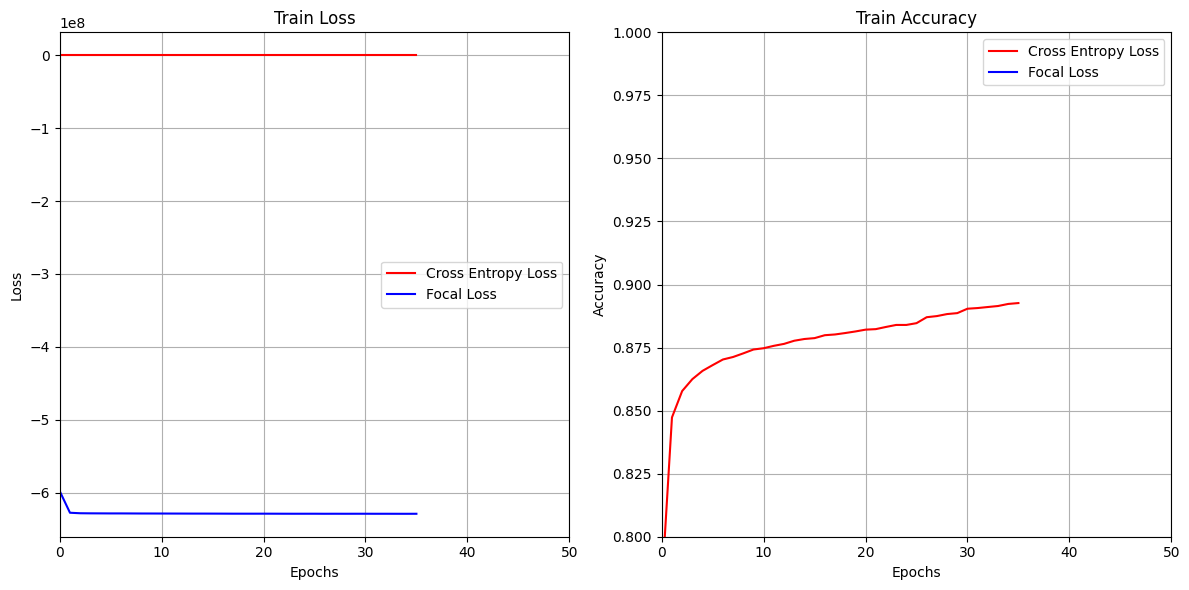

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange", "cyan", "magenta", "brown", "pink"]


plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Loss Function"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Loss Function"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_losses_{_time}.png")
plt.show()